

# Prediction of the KS system: a model using Convolutional Neural Network

In this notebook, I will use a model of Deep Learning to predict the KS system. More precisely, we wanna predict the next step of a given history of state of the system. To do it, a simple convolutional neural network will be used. It is just the first model trained to predict the system. I will try many configurations and varieties.

To generate the data, I will use the KS.py code provided by Alessandro Bucci.

In [0]:
#Set a javascript interval to click on the connect button every 60 seconds. 
#Open developer-settings (in your web-browser) with Ctrl+Shift+i then click 
#on console tab and type this on the console prompt.
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

In [0]:
import numpy as np
import torch as th
import time
from scipy import stats
from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [0]:
def generatingdata(state_initial, length,sample_points,dt,final_time):
    """
    This function will generate data from the KS.py simulation
    
    input:
    - state_initial: the initial/current state of the system
    - length: the "physical" length of the domaine. 
              pay attention cuz this value will determine if the system is regular or chaotic
    - sample_points: the number of sample points on this length. It will be the size of the input in our system
    - dt: the time step of the simulation
    - final_time: the total time of simulation
    in this way, the number of iteraction of the simulation will final_time/dt
    
    
    output:
    - return: state_history, time_counter, position_x
    - print: state_history.shape et final_time
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    
    """
    ks = KS(L=length,N=sample_points,dt=dt) #class of the simulation
    total_iteractions = int(np.round(final_time/dt))
    print("Running for : ",final_time, 'seconds', 'with', total_iteractions, 'iteractions')
    time_counter = 0 
    action = np.zeros(1) # in this simulation, we will set actions=0
    state_history = np.matrix(state_initial) # We will stack in state_history at each time step
    
    current_state = state_initial
    for nt in range(total_iteractions): 
        current_state = ks.advance(current_state,action)
        state_history = np.vstack((state_history,current_state))
        time_counter = np.hstack((time_counter,(nt+1)*ks.dt))
        if nt==100:
          print('100th iteraction: ok')
        if nt==1000:
          print('1000th iteraction: ok')
        if nt==2500:
          print('2500th iteraction: ok')
        if nt==5000:
          print('5000th iteraction: ok')
        if nt==10000:
          print('10000th iteraction: ok')
        if nt==50000:
          print('50000th iteraction: ok')
        if nt==75000:
          print('75000th iteraction: ok')
        if nt==100000:
          print('100000th iteraction: ok')
    
    position_x=ks.x
    # Explore the results 
    print('The state_history shape is:', state_history.shape)
    print('The final time:', time_counter[-1])
    
    return state_history, time_counter, position_x

In [0]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [0]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [0]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [0]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [0]:
def prediction(model,start_position,N_step_pred,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """
    
    y_true=state_history_norm_th[:,start_position:start_position+N_step_pred,:].squeeze()
    sample_points=state_history_norm_th.size(2)
    current_state = state_history_norm_th[:,start_position-100:start_position,:]
    prediction_model = th.zeros((N_step_pred, sample_points))

    for i in range(N_step_pred):
        y=model(current_state)
        past=current_state[:,1:100,:]
        current_state=th.zeros(1,100,64).double().cuda()
        current_state[:,0:99,:]=past
        current_state[:,99,:]=y
        prediction_model[i,:]=y.squeeze()


    prediction_model_np = prediction_model.detach().numpy()
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4)

    plt.plot(np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('Delta')
    plt.xlabel('Time step')

## Data Generation
First, let's set the parameters of the simulation:

In [0]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u3.dat') #the observed initial state of the system

Take a look on the observation:

Text(0.5, 1.0, 'Initial State')

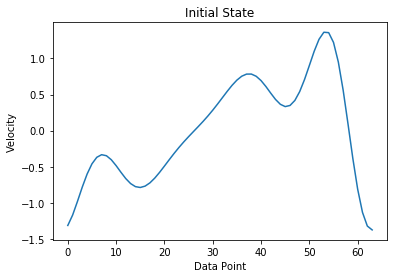

In [0]:
plt.plot(state_initial)
plt.xlabel('Data Point')
plt.ylabel('Velocity')
plt.title('Initial State')

Generating data from simulation or loading the already generated data

In [0]:
#to generate data

#state_history, time_counter, position_x = generatingdata(state_initial, length,sample_points,dt,final_time)

#to save the generated data
from numpy import savetxt
# save to csv file
# savetxt('state_history.dat', state_history)
# savetxt('time_counter.dat', time_counter)
# savetxt('position.dat', ks.x)

Running for :  1000 seconds with 10000 iteractions
100th iteraction: ok
1000th iteraction: ok
2500th iteraction: ok
5000th iteraction: ok
The state_history shape is: (10001, 64)
The final time: 1000.0


In [9]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


## Exploring the data
Let's take a look at the generated or loaded data:

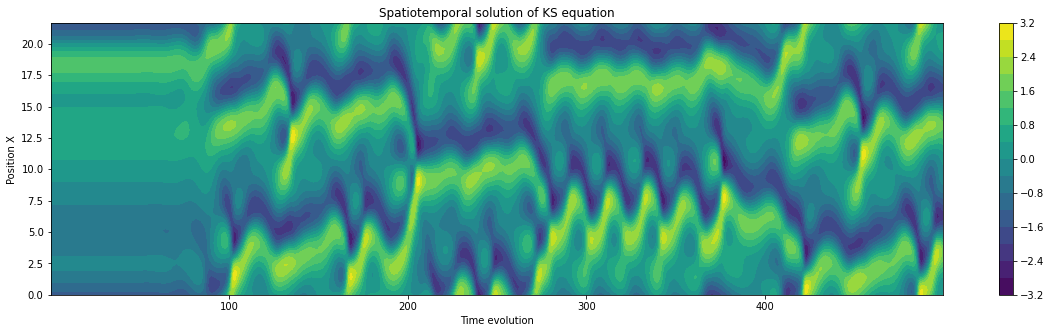

Mean: 7.18738037725911e-05
Median: 0.021496211882703124
Max: 1.3621388257532678
Min: -1.373943449141367
Mode: ModeResult(mode=array([-1.37394345]), count=array([1]))
Variance: 0.5217471712979933


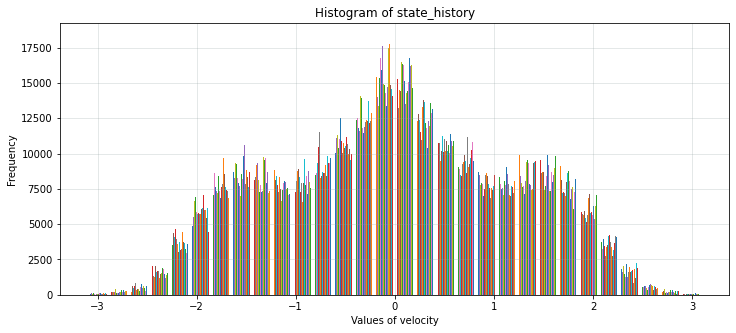

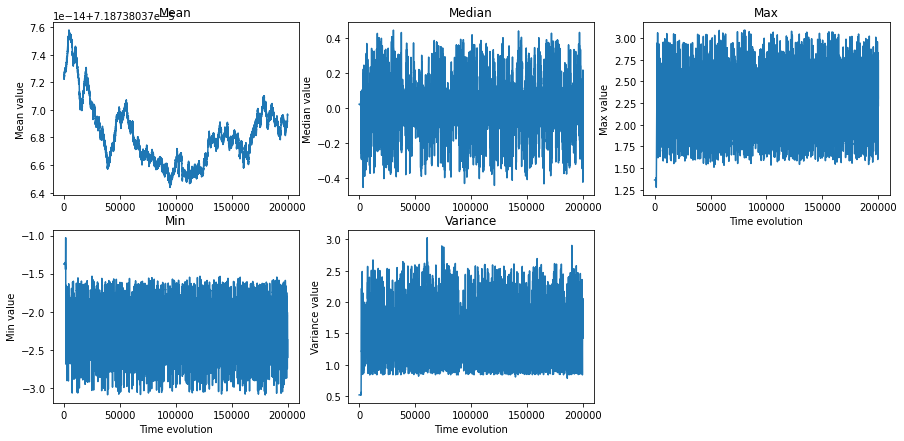

In [13]:
state_history = np.squeeze(np.asarray(state_history))

#visualizing the solution of KS equation
drawKS(state_history[0:10000,:], position_x, time_counter[0:10000],1,int(time_counter[-1]),20,4)


#histogram
plothist(state_history,bins=30)

#statistic values
statvalues(state_history[0,:])

#evolution of statistic values
evolutionstat(state_history)


Zoom to see the maximum peaks:

In [0]:
#print(state_history.shape)
#print(np.max(state_history[4200:4300],axis=1))
#n=4235
#m=4000
#plt.plot(state_history[n,:], label=n)
#plt.plot(state_history[m,:], label=m)
#plt.xlabel('Data Point')
#plt.ylabel('Velocity')
#plt.legend()

#print(np.max(state_history,axis=1)[n])
#print(np.max(state_history,axis=1)[m])

#drawKS(state_history[4000:4300], position_x, time_counter[4000:4300],1,int(time_counter[-1]),20,4)

Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

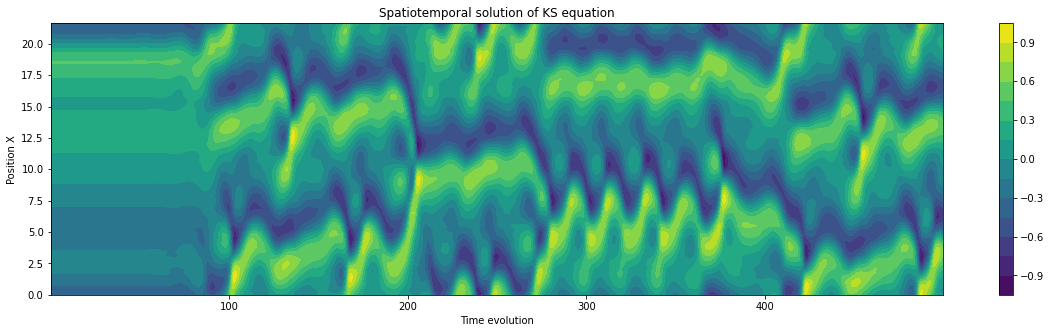

Mean: 0.0037720958739586776
Median: 0.02334210639889245
Max: 0.4565350850600155
Min: -0.4433889069435318
Mode: ModeResult(mode=array([-0.44338891]), count=array([1]))
Variance: 0.05437736519905126


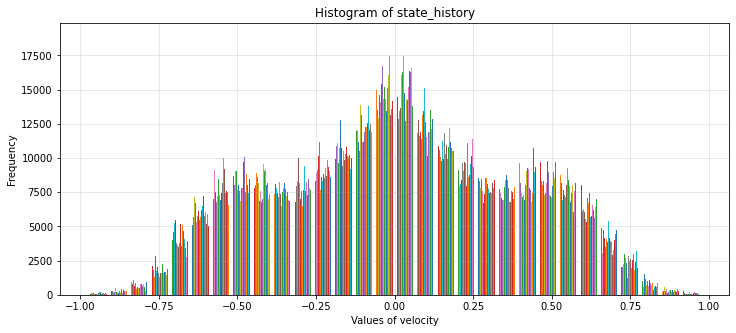

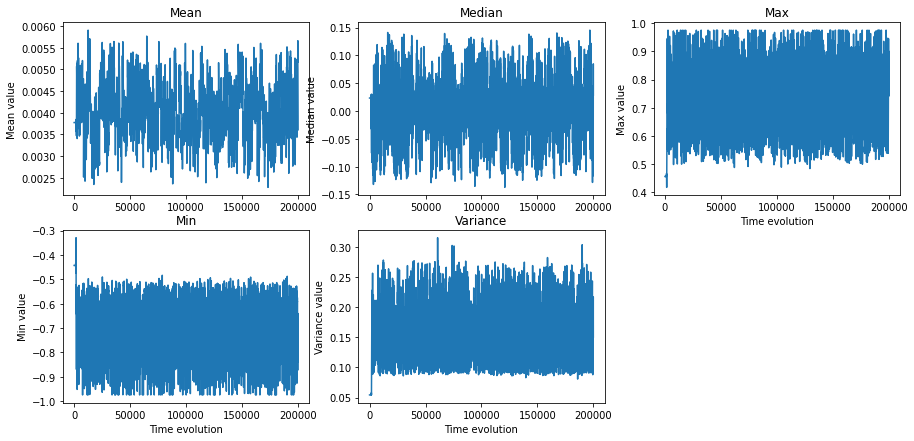

In [39]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#visualizing the solution of KS equation
drawKS(state_history_norm, position_x, time_counter,1,int(time_counter[-1]),20,4)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

## Separating the data into training and test sets

In [40]:
state_history_norm=state_history_norm[100000:200000,:]
#até 100.000 vai, com 200.000 o colabs nao aguenta
state_history_norm.shape

(100000, 64)

In [0]:
size_conv_time=100
X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

NN = state_history_norm.shape[0]-2*size_conv_time
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation


np.random.seed(0)
indices=np.arange(NN)
np.random.shuffle(indices)
train_ind=indices[0:Nt]
valid_ind=indices[-Nv:]

X_train = np.zeros((Nt, size_conv_time, sample_points))
aux=0
for ind in train_ind:
    X_train[aux,:,:]=X[ind:ind+size_conv_time]
    aux=aux+1

Y_train = Y[train_ind]

X_valid = np.zeros((Nv, size_conv_time, sample_points))
aux=0
for ind in valid_ind:
    X_valid[aux,:,:]=X[ind:ind+size_conv_time]
    aux=aux+1

Y_valid = Y[valid_ind]


#converting to tensor
X_train_th = th.from_numpy(X_train).cuda()
Y_train_th = th.from_numpy(Y_train).cuda()
X_valid_th = th.from_numpy(X_valid).cuda()
Y_valid_th = th.from_numpy(Y_valid).cuda()

## Training

In [0]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=30,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.7f}..\t".format(train_losses[-1]),"{:.7f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    print("{}\t".format(e+1),"{:.7f}..\t".format(train_losses[-1]),"{:.7f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.7f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    ax.set_ylim(bottom=0)
    return train_losses, valid_losses

## Model 1

In [0]:
Lin = sample_points
in_ch_conv_1 = size_conv_time
out_ch_conv_1 = 5
k_conv_1 = 3
st_conv_1 = 1
pad_conv_1 = 1
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1


in_ch_conv_2 = 5
out_ch_conv_2 = 1
k_conv_2 = 3
st_conv_2 = 1
pad_conv_2 = 1
L_3 = (L_2+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

in_lin = sample_points
out_lin = sample_points


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()

Epoch	Train Loss	Valid Loss
0	 0.3182820..	 0.3172099..
1	 0.1199053..	 0.0481221..
2	 0.0331002..	 0.0222032..
3	 0.0176679..	 0.0140265..
4	 0.0126812..	 0.0115601..
5	 0.0111863..	 0.0106606..
6	 0.0104980..	 0.0102084..
7	 0.0101221..	 0.0099172..
8	 0.0098717..	 0.0097372..
9	 0.0096990..	 0.0095255..
10	 0.0095649..	 0.0094494..
11	 0.0094466..	 0.0092685..
12	 0.0093487..	 0.0091848..
13	 0.0092676..	 0.0091437..
14	 0.0091973..	 0.0090786..
15	 0.0091385..	 0.0089611..
16	 0.0090895..	 0.0090183..
17	 0.0090407..	 0.0089427..
18	 0.0090081..	 0.0088924..
19	 0.0089686..	 0.0088166..
20	 0.0089360..	 0.0088725..
21	 0.0089085..	 0.0087575..
22	 0.0088702..	 0.0087700..
23	 0.0088603..	 0.0087517..
24	 0.0088241..	 0.0087439..
25	 0.0088057..	 0.0086979..
26	 0.0087810..	 0.0086693..
27	 0.0087595..	 0.0086689..
28	 0.0087370..	 0.0086946..
29	 0.0087237..	 0.0086404..
30	 0.0087117..	 0.0085934..
31	 0.0086895..	 0.0086115..
32	 0.0086699..	 0.0088263..
33	 0.0086633..	 0.008611

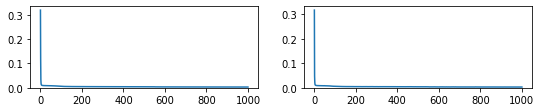

In [15]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [0]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv1_model1_u3")

The true solution:


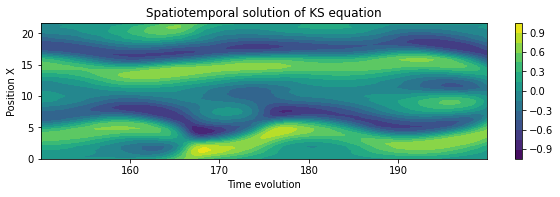

The model solution:


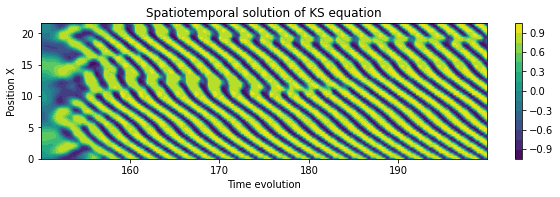

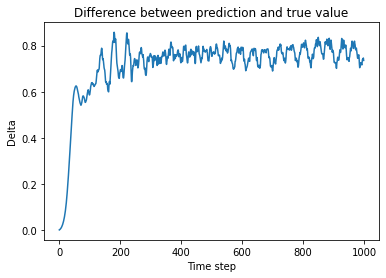

In [19]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
state_history_norm_th = state_history_norm_th.unsqueeze(0)
#epochs=1000
start_position=3000
N_step_pred=1000
prediction(model,start_position,N_step_pred,state_history_norm_th)

# Model 2

In [0]:
Lin = sample_points
in_ch_conv_1 = size_conv_time
out_ch_conv_1 = 50
k_conv_1 = 3
st_conv_1 = 1
pad_conv_1 = 1
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1


in_ch_conv_2 = 50
out_ch_conv_2 = 25
k_conv_2 = 3
st_conv_2 = 1
pad_conv_2 = 1
L_3 = (L_2+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

in_ch_conv_3 = 25
out_ch_conv_3 = 1
k_conv_3 = 3
st_conv_3 = 1
pad_conv_3 = 1
L_4 = (L_3+2*pad_conv_3-(k_conv_3-1)-1)/st_conv_3+1

in_lin = sample_points
out_lin = sample_points
hidden_lin = sample_points*2


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.Conv1d(in_ch_conv_3,out_ch_conv_3,k_conv_3,st_conv_3,pad_conv_3),
    th.nn.LeakyReLU(),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()

Epoch	Train Loss	Valid Loss
0	 0.3168090..	 0.3157658..
1	 0.0611155..	 0.0162193..
2	 0.0134302..	 0.0114627..
3	 0.0107014..	 0.0103639..
4	 0.0095690..	 0.0090971..
5	 0.0089261..	 0.0090653..
6	 0.0084626..	 0.0086282..
7	 0.0080873..	 0.0076412..
8	 0.0077552..	 0.0074120..
9	 0.0074641..	 0.0072300..
10	 0.0072642..	 0.0068799..
11	 0.0070659..	 0.0068062..
12	 0.0069122..	 0.0066434..
13	 0.0067958..	 0.0065498..
14	 0.0066803..	 0.0064503..
15	 0.0065830..	 0.0065076..
16	 0.0064857..	 0.0061882..
17	 0.0064027..	 0.0061021..
18	 0.0063004..	 0.0060616..
19	 0.0062272..	 0.0061191..
20	 0.0061511..	 0.0059626..
21	 0.0061037..	 0.0062360..
22	 0.0060487..	 0.0058475..
23	 0.0059747..	 0.0058667..
24	 0.0059247..	 0.0059043..
25	 0.0058587..	 0.0058118..
26	 0.0058142..	 0.0056377..
27	 0.0057691..	 0.0057681..
28	 0.0057224..	 0.0054919..
29	 0.0056846..	 0.0057165..
30	 0.0056325..	 0.0055477..
31	 0.0055760..	 0.0055248..
32	 0.0055857..	 0.0054776..
33	 0.0054999..	 0.005391

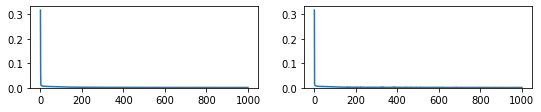

In [26]:
epochs_counter=1000
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [0]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv1_model2_u3")

The true solution:


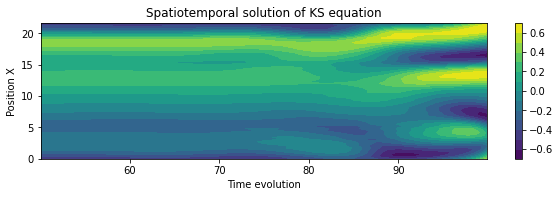

The model solution:


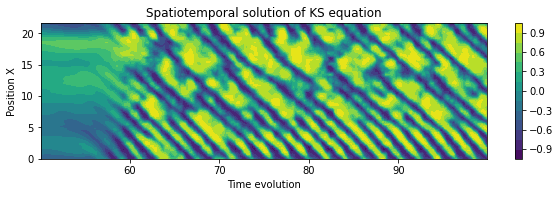

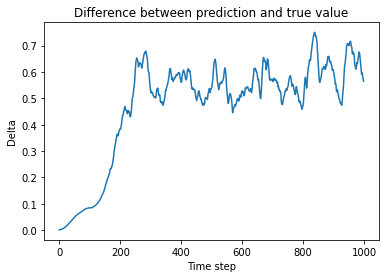

In [29]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=1000
N_step_pred=1000
prediction(model,start_position,N_step_pred,state_history_norm_th)

## Model 3

In [0]:
Lin = sample_points
in_ch_conv_1 = size_conv_time
out_ch_conv_1 = 50
k_conv_1 = 3
st_conv_1 = 1
pad_conv_1 = 1
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1


in_ch_conv_2 = 50
out_ch_conv_2 = 25
k_conv_2 = 3
st_conv_2 = 1
pad_conv_2 = 1
L_3 = (L_2+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

in_ch_conv_3 = 25
out_ch_conv_3 = 1
k_conv_3 = 3
st_conv_3 = 1
pad_conv_3 = 1
L_4 = (L_3+2*pad_conv_3-(k_conv_3-1)-1)/st_conv_3+1

in_lin = sample_points
out_lin = sample_points
hidden_lin1 = sample_points*3
hidden_lin2 = sample_points*2


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.Conv1d(in_ch_conv_3,out_ch_conv_3,k_conv_3,st_conv_3,pad_conv_3),
    th.nn.LeakyReLU(),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin1,hidden_lin2),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()

Epoch	Train Loss	Valid Loss
0	 0.0012862..	 0.0012974..
1	 0.0013245..	 0.0015356..
2	 0.0013407..	 0.0012863..
3	 0.0013220..	 0.0012152..
4	 0.0013247..	 0.0012292..
5	 0.0013171..	 0.0013900..
6	 0.0013233..	 0.0012733..
7	 0.0013126..	 0.0012342..
8	 0.0013239..	 0.0012207..
9	 0.0013121..	 0.0013840..
10	 0.0013006..	 0.0015593..
11	 0.0013012..	 0.0012987..
12	 0.0013218..	 0.0013088..
13	 0.0012847..	 0.0011377..
14	 0.0012821..	 0.0014420..
15	 0.0013129..	 0.0011926..
16	 0.0013002..	 0.0015700..
17	 0.0012786..	 0.0014545..
18	 0.0013159..	 0.0015296..
19	 0.0012860..	 0.0013305..
20	 0.0012914..	 0.0013326..
21	 0.0012930..	 0.0013023..
22	 0.0012937..	 0.0011419..
23	 0.0012804..	 0.0013749..
24	 0.0012740..	 0.0012105..
25	 0.0012963..	 0.0011998..
26	 0.0012754..	 0.0011437..
27	 0.0012911..	 0.0012929..
28	 0.0012639..	 0.0013185..
29	 0.0012786..	 0.0014304..
30	 0.0012746..	 0.0012009..
31	 0.0012717..	 0.0011045..
32	 0.0012814..	 0.0012143..
33	 0.0012795..	 0.001297

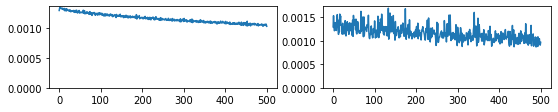

In [43]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [0]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv1_model3_u3")

The true solution:


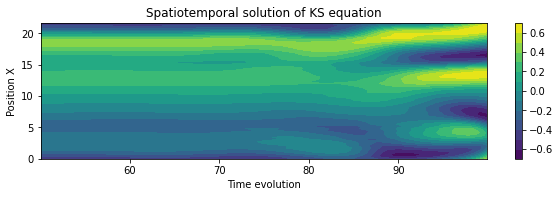

The model solution:


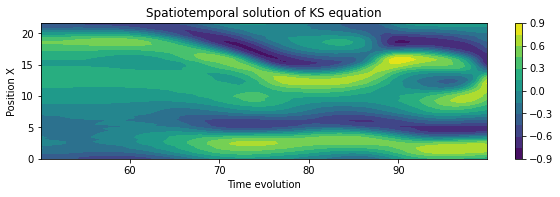

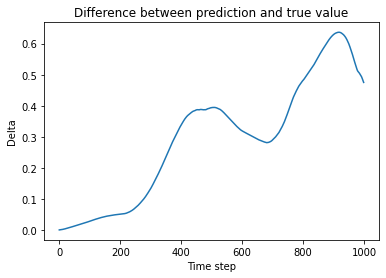

In [34]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=1000
N_step_pred=1000
prediction(model,start_position,N_step_pred,state_history_norm_th)